# Vergleich der Tabellen 'transactions'

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind, chi2_contingency

# Daten laden
df_train = pd.read_parquet('data/transactions_train_1.parquet')
df_test = pd.read_parquet('data/transactions_test_1.parquet')

## Überblick Trainingsdaten

In [2]:
# 1. Überblick
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558245 entries, 0 to 1558244
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id                 1558245 non-null  object        
 1   store_id           1558245 non-null  object        
 2   cash_desk          1558245 non-null  int64         
 3   transaction_start  1558245 non-null  datetime64[us]
 4   transaction_end    1558245 non-null  datetime64[us]
 5   total_amount       1558245 non-null  float64       
 6   n_lines            1558245 non-null  int64         
 7   payment_medium     1558245 non-null  object        
 8   customer_feedback  108330 non-null   float64       
 9   damage             155692 non-null   float64       
 10  label              1558245 non-null  object        
dtypes: datetime64[us](2), float64(3), int64(2), object(4)
memory usage: 130.8+ MB
None


## Überblick Testdaten

In [3]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811905 entries, 0 to 811904
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 811905 non-null  object        
 1   store_id           811905 non-null  object        
 2   cash_desk          811905 non-null  int64         
 3   transaction_start  811905 non-null  datetime64[us]
 4   transaction_end    811905 non-null  datetime64[us]
 5   total_amount       811905 non-null  float64       
 6   n_lines            811905 non-null  int64         
 7   payment_medium     811905 non-null  object        
 8   customer_feedback  81524 non-null   float64       
dtypes: datetime64[us](2), float64(2), int64(2), object(3)
memory usage: 55.7+ MB
None


## Vergleich numerischer Daten

cash_desk: KS-Test p-Wert = 0.99713


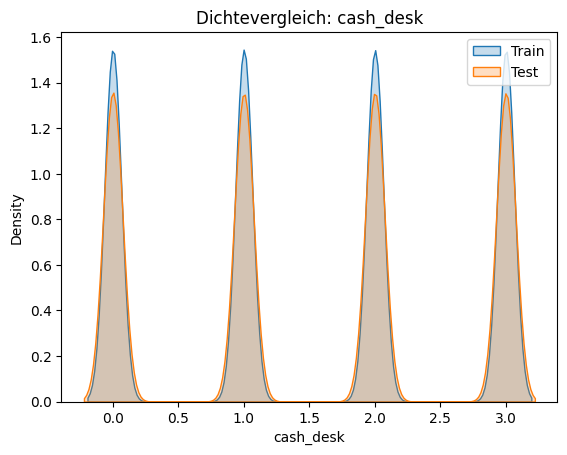

total_amount: KS-Test p-Wert = 0.00000


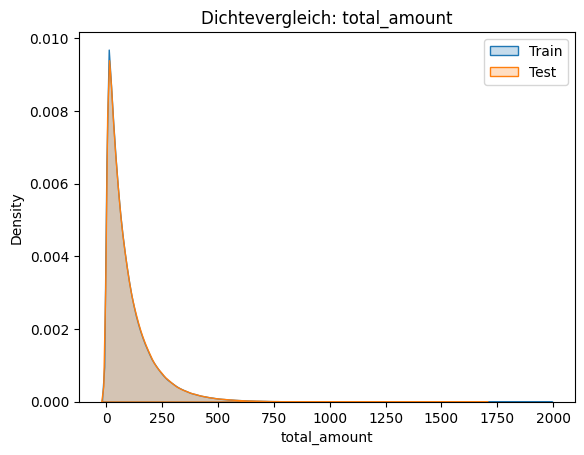

n_lines: KS-Test p-Wert = 0.42639


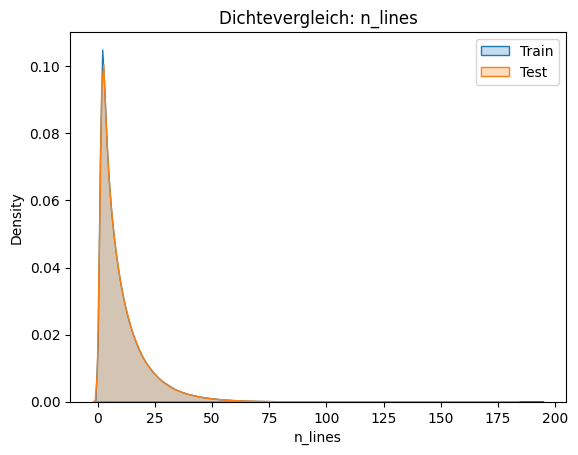

customer_feedback: KS-Test p-Wert = 1.00000


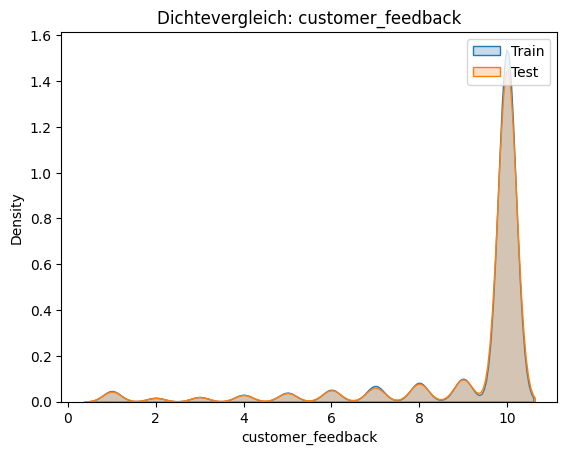

In [5]:
# Spaltenschnittmenge ermitteln (nur gemeinsame Spalten)
common_cols = df_train.columns.intersection(df_test.columns)

# Nur numerische gemeinsame Spalten vergleichen
numerical_cols = df_train[common_cols].select_dtypes(include='number').columns

# KS-Test für numerische Features
for col in numerical_cols:
    train_vals = df_train[col].dropna()
    test_vals = df_test[col].dropna()
    
    stat, p = ks_2samp(train_vals, test_vals)
    print(f"{col}: KS-Test p-Wert = {p:.5f}")
    
    sns.kdeplot(train_vals, label='Train', fill=True)
    sns.kdeplot(test_vals, label='Test', fill=True)
    plt.title(f'Dichtevergleich: {col}')
    plt.legend()
    plt.show()

--> Im Rahmen der explorativen Datenanalyse wurden die numerischen Merkmale in den Tabellen transaction_train nd transaction_test auf Verteilungsgleichheit geprüft. Bis auf das Merkmal total_amount zeigten alle Features keine signifikanten Unterschiede. Das Merkmal total_amount weist eine statistisch signifikante Abweichung in der Verteilung auf, was in späteren Modellierungsphasen berücksichtigt wird. 

## Vergleich kategorischer Daten

id: Chi-Quadrat-Test p-Wert = 0.39458 (Top 20 Kategorien)


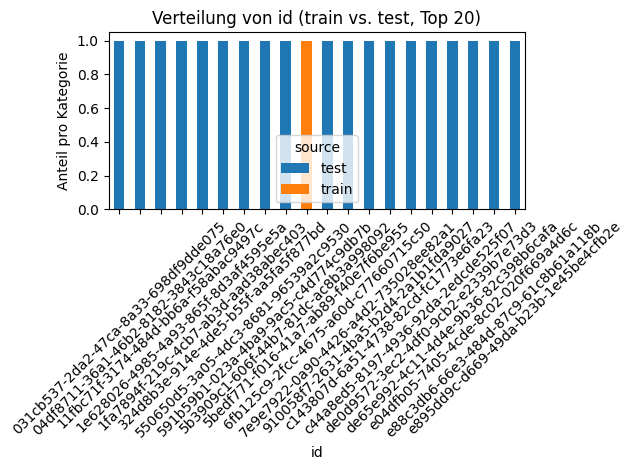

store_id: Chi-Quadrat-Test p-Wert = 0.02227 (Top 20 Kategorien)


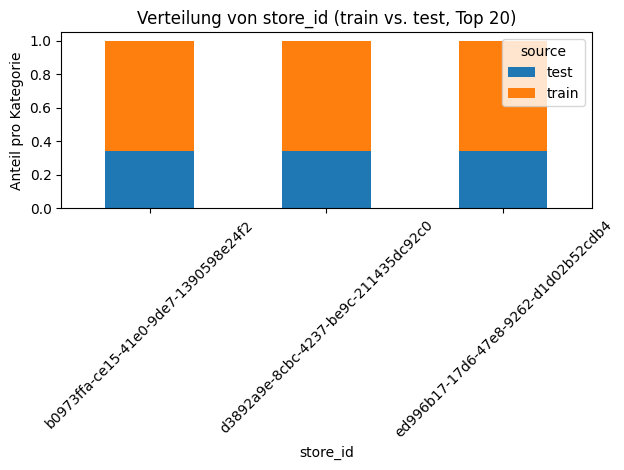

payment_medium: Chi-Quadrat-Test p-Wert = 0.00000 (Top 20 Kategorien)


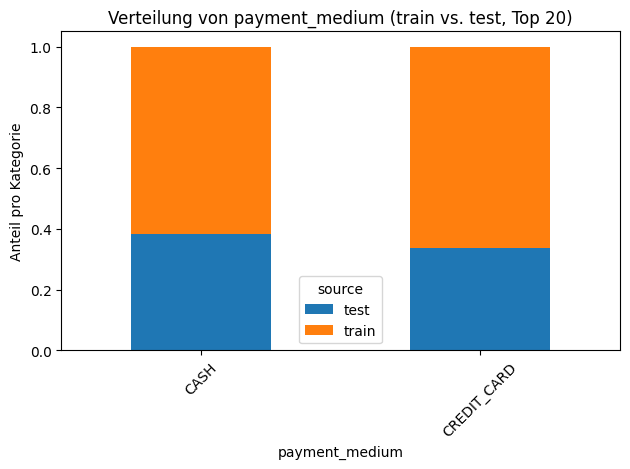

In [4]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt

# Nur gemeinsame kategoriale Spalten
common_cols = df_train.columns.intersection(df_test.columns)
categorical_cols = df_train[common_cols].select_dtypes(include=['object', 'category']).columns

# Kombinierten DataFrame mit Kennzeichnung der Quelle
df_train_ = df_train[categorical_cols].copy()
df_train_['source'] = 'train'

df_test_ = df_test[categorical_cols].copy()
df_test_['source'] = 'test'

df_all = pd.concat([df_train_, df_test_], axis=0)

# Chi-Quadrat-Test pro Spalte
TOP_K = 20  # Anzahl der häufigsten Kategorien

for col in categorical_cols:
    # Häufigste Kategorien in train + test
    top_cats = df_all[col].value_counts().nlargest(TOP_K).index

    df_filtered = df_all[df_all[col].isin(top_cats)]

    contingency = pd.crosstab(df_filtered[col], df_filtered['source'])

    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency)
        print(f"{col}: Chi-Quadrat-Test p-Wert = {p:.5f} (Top {TOP_K} Kategorien)")

        contingency.div(contingency.sum(1), axis=0).plot(kind='bar', stacked=True)
        plt.title(f"Verteilung von {col} (train vs. test, Top {TOP_K})")
        plt.ylabel("Anteil pro Kategorie")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{col}: Nicht genug Variation für Chi-Quadrat-Test.")

--> Für die Analyse der kategorialen Merkmale wurde ein Chi-Quadrat-Test auf Verteilungsgleichheit durchgeführt. Während id wie erwartet keine Unterschiede zeigte (p = 0.39), ergaben sich signifikante Unterschiede bei store_id (p = 0.02) und payment_medium (p < 0.001). Insbesondere die Verteilung der Zahlungsmittel weicht in den Testdaten erheblich ab. Dieses Ergebnis wurde visuell validiert und fließt in die spätere Modellvalidierung und Featureauswahl ein.